# Analyze time

# Purpose
* There could be missing data in either AIS, GPS or both, this notebook will investigate this.

# Methodology
* Load AIS dat from SSPA AIS DB
* Load GPS data
* compare time stamps.

# Setup

In [1]:
# %load imports.py
from typing import no_type_check
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from pyaisdb.database import DB



Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from shapely.geometry import Point

In [3]:
db = DB()

The analysis will be carried out between the following dates and for a ship with MMSI number as below:

In [4]:
date1 = '2020-07-10 00:00:00+02'
date2 = '2020-07-19 23:59:59+02'
mmsi = 265520390
sog_min = 1

## AIS
Loading data from SSPA AIS DB. In this DB the AIS data has been transformed into segments including some data reduction including.

In [5]:
sql = f"""select *, st_length(segment::geography)
from segments_sjfv_2020
where sog>={sog_min}
and mmsi={265520390}
and date2 < '{date2}'
and date1 > '{date1}' """

df_ais = gpd.GeoDataFrame.from_postgis(sql, db.conn, geom_col='segment', index_col='date1')

df_ais['segment_time'] = pd.TimedeltaIndex(df_ais['date2']-df_ais.index).total_seconds()

df_ais.sort_index(inplace=True)
assert df_ais.index.is_unique

In [6]:
df_ais.describe()

,rowid,mmsi,cog,sog,route_id,state_id,heading,st_length,segment_time
count,1.928800e+04,19288.0,19288.000000,19288.000000,1.928800e+04,19288.0,19288.000000,19288.000000,19288.000000
mean,9.734050e+07,265520390.0,174.460286,11.839439,4.931496e+06,86124.0,177.131066,104.517458,16.163003
std,1.590177e+06,0.0,102.462962,5.265339,8.493025e+04,0.0,102.469308,157.174258,19.319090
min,9.479929e+07,265520390.0,0.000000,1.000000,4.787771e+06,86124.0,0.000000,10.026185,3.000000
25%,9.598232e+07,265520390.0,79.000000,7.900000,4.864799e+06,86124.0,81.000000,30.074539,7.000000
50%,9.721796e+07,265520390.0,186.000000,11.600000,4.926456e+06,86124.0,191.000000,56.079606,10.000000
75%,9.866020e+07,265520390.0,258.000000,16.700000,4.999347e+06,86124.0,261.000000,107.042163,17.000000
max,1.000820e+08,265520390.0,359.000000,22.100000,5.078848e+06,86124.0,359.000000,2777.274972,357.000000


In [7]:
df_ais.head()

,rowid,mmsi,date2,segment,cog,sog,route_id,state_id,heading,st_length,segment_time
date1,,,,,,,,,,,
2020-07-10 04:39:25+00:00,94799291,265520390,2020-07-10 04:39:35+00:00,"LINESTRING (18.84406 59.50179, 18.84415 59.50168)",165,2.1,4787771,86124,338,13.272280,10.0
2020-07-10 04:39:35+00:00,94799336,265520390,2020-07-10 04:39:45+00:00,"LINESTRING (18.84415 59.50168, 18.84434 59.50155)",150,3.2,4787771,86124,327,18.042806,10.0
2020-07-10 04:39:45+00:00,94799367,265520390,2020-07-10 04:39:52+00:00,"LINESTRING (18.84434 59.50155, 18.84450 59.50147)",136,3.7,4787771,86124,318,12.710169,7.0
2020-07-10 04:39:52+00:00,94799574,265520390,2020-07-10 04:40:37+00:00,"LINESTRING (18.84450 59.50147, 18.84432 59.50140)",135,3.1,4787771,86124,312,12.835326,45.0
2020-07-10 04:40:37+00:00,94799626,265520390,2020-07-10 04:40:48+00:00,"LINESTRING (18.84432 59.50140, 18.84413 59.50127)",234,2.1,4787771,86124,219,18.042858,11.0


<AxesSubplot:>

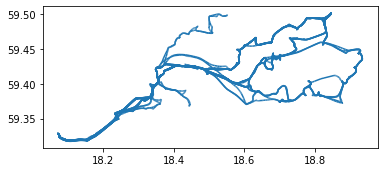

In [8]:
df_ais.plot()

## Segments to points
The AIS segments are split into points, to make a more fair comparison to the GPS points (below).

In [9]:
rows = []

for index,s in df_ais.iterrows():

    s = s.copy()
    segment = s['segment']
    point0 = Point(segment.coords[0])
    point1 = Point(segment.coords[1])
    
    date0_ = index
    date1_ = s.pop('date2')
    
    s0 = s.copy()
    s0['pos'] = point0
    s0.name = date0_

    s1 = s.copy()
    s1['pos'] = point1
    s1.name = date1_

    rows.append(s0)
    rows.append(s1)
        
df_ais_pos = pd.DataFrame(rows)
df_ais_pos['geometry'] = gpd.GeoSeries(df_ais_pos['pos'])
df_ais_pos_raw = gpd.GeoDataFrame(df_ais_pos)

In [10]:
mask = df_ais_pos_raw.index.duplicated(keep='first')
df_ais_pos = df_ais_pos_raw.loc[~mask].copy()
df_ais_pos.sort_index(inplace=True)
assert df_ais_pos.index.is_unique

Here is a description of the AIS data points:
(Note that the length of the original segment is stored as: *"st_length"*)

In [11]:
df_ais_pos.describe()

,rowid,mmsi,cog,sog,route_id,state_id,heading,st_length,segment_time
count,1.988200e+04,19882.0,19882.000000,19882.000000,1.988200e+04,19882.0,19882.000000,19882.000000,19882.000000
mean,9.734297e+07,265520390.0,174.266724,11.602761,4.931634e+06,86124.0,177.381803,102.081859,16.022784
std,1.587680e+06,0.0,102.548910,5.369706,8.479308e+04,0.0,102.624477,155.455207,19.244083
min,9.479929e+07,265520390.0,0.000000,1.000000,4.787771e+06,86124.0,0.000000,10.026185,3.000000
25%,9.598384e+07,265520390.0,79.000000,7.600000,4.864947e+06,86124.0,81.000000,28.455688,7.000000
50%,9.722076e+07,265520390.0,184.500000,11.400000,4.926456e+06,86124.0,192.000000,54.059551,10.000000
75%,9.865956e+07,265520390.0,258.000000,16.400000,4.999347e+06,86124.0,261.000000,104.214793,17.000000
max,1.000820e+08,265520390.0,359.000000,22.100000,5.078848e+06,86124.0,359.000000,2777.274972,357.000000


## GPS
Loading the GPS data, which is given as points, the Lat/Lon position of the ship.

In [12]:
sql = f"""select * 
  FROM projects._49145341_d2e2f_blue_data_varmdo
	where time_info < '{date2}'
                  and time_info > '{date1}'
and sog >= {sog_min}"""
df_gps = gpd.GeoDataFrame.from_postgis(sql, db.conn, geom_col='pos', index_col='time_info') 
df_gps.sort_index(inplace=True)
assert df_gps.index.is_unique

In [13]:
df_gps.describe()

,row_id,sog
count,3.199010e+05,319901.000000
mean,1.224437e+06,12.425095
std,2.484238e+05,5.423723
min,8.015560e+05,1.000000
25%,1.011481e+06,8.600000
50%,1.237274e+06,12.300000
75%,1.432420e+06,18.000000
max,1.628487e+06,22.200000


In [14]:
s = df_gps.iloc[0]

In [15]:
position = s['pos']
position.x

18.8441

In [16]:
position.y

59.5019

Plot of the AIS and GPS points:

<AxesSubplot:>

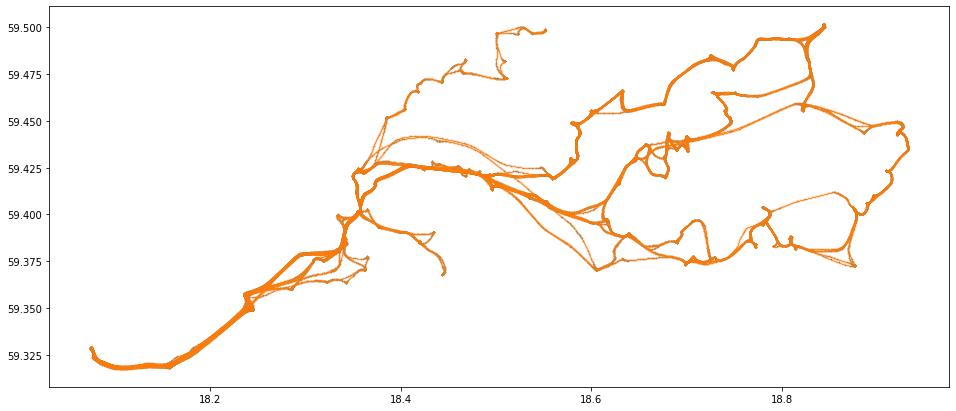

In [17]:
fig,ax=plt.subplots()
fig.set_size_inches(17,7)
df_ais_pos.plot(markersize=0.2, label='AIS', ax=ax)
df_gps.plot(markersize=0.2, label='GPS', ax=ax, alpha=0.2)

In [18]:
df_gps.describe()

,row_id,sog
count,3.199010e+05,319901.000000
mean,1.224437e+06,12.425095
std,2.484238e+05,5.423723
min,8.015560e+05,1.000000
25%,1.011481e+06,8.600000
50%,1.237274e+06,12.300000
75%,1.432420e+06,18.000000
max,1.628487e+06,22.200000


In [19]:
df_gps.head()

,row_id,sog,pos
time_info,,,
2020-07-10 04:39:15+00:00,801556,1.0,POINT (18.84410 59.50190)
2020-07-10 04:39:16+00:00,801557,1.1,POINT (18.84410 59.50190)
2020-07-10 04:39:17+00:00,801558,1.2,POINT (18.84409 59.50189)
2020-07-10 04:39:18+00:00,801559,1.2,POINT (18.84409 59.50188)
2020-07-10 04:39:19+00:00,801560,1.2,POINT (18.84409 59.50188)


## Cutting the same time window for AIS and GPS

In [20]:
start = np.max([df_gps.index[0], df_ais_pos.index[0]])
stop = np.min([df_gps.index[-1], df_ais_pos.index[-1]])
mask = ((df_gps.index >=start) & (df_gps.index<=stop))
df_gps = df_gps.loc[mask].copy()

mask = ((df_ais_pos.index >=start) & (df_ais_pos.index<=stop))
df_ais_pos = df_ais_pos.loc[mask].copy()

In [21]:
df_gps['t'] = (df_gps.index-df_gps.index[0]).total_seconds().values
df_ais_pos['t'] = (df_ais_pos.index-df_gps.index[0]).total_seconds().values  # Note that t0 is taken from GPS

In [22]:
df_ais_pos['t']

2020-07-10 04:39:25+00:00         0.0
2020-07-10 04:39:35+00:00        10.0
2020-07-10 04:39:45+00:00        20.0
2020-07-10 04:39:52+00:00        27.0
2020-07-10 04:40:37+00:00        72.0
                               ...   
2020-07-19 18:20:43+00:00    826878.0
2020-07-19 18:20:49+00:00    826884.0
2020-07-19 18:20:53+00:00    826888.0
2020-07-19 18:21:06+00:00    826901.0
2020-07-19 18:21:16+00:00    826911.0
Name: t, Length: 19882, dtype: float64

From a visual inspection it seems that both AIS and GPS have data for the same times:

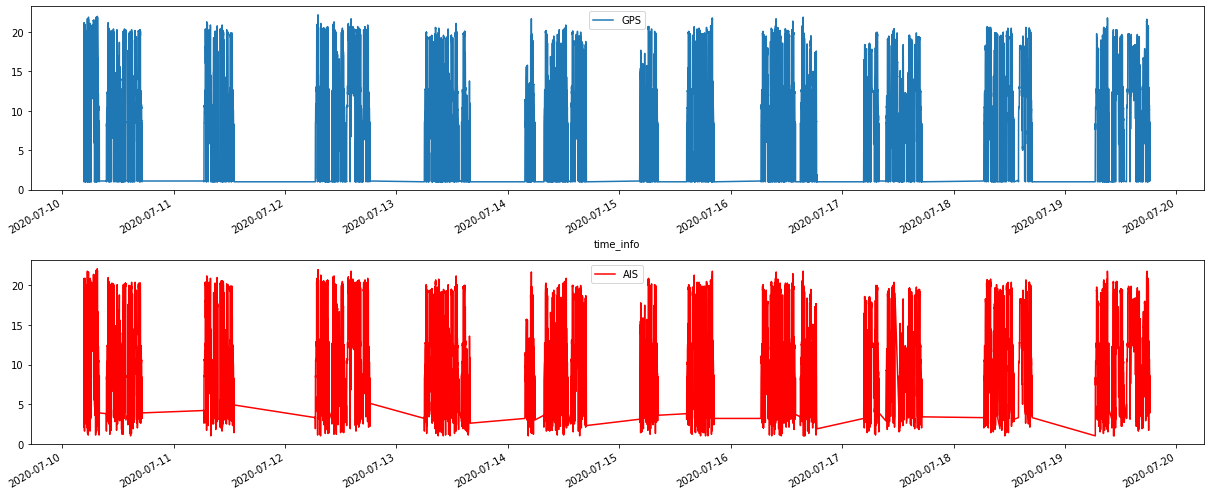

In [23]:
fig,axes=plt.subplots(nrows=2)
fig.set_size_inches(17,7)
df_gps.plot(y='sog', kind='line', ax=axes[0], label='GPS')
df_ais_pos.plot(y='sog', kind='line', ax=axes[1], label='AIS', style='r-')
plt.tight_layout()



Zooming in on a couple of hours of the time series, it seems that there are small deviations between the AIS and GPS.

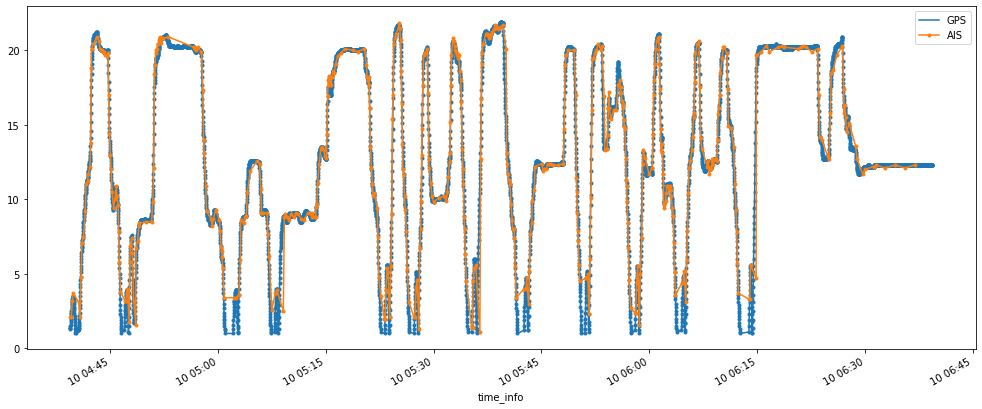

In [25]:
fig,ax=plt.subplots()
fig.set_size_inches(17,7)

stop_date = '2020-07-10 06:39:25+00:00'
mask = df_gps.index < stop_date
df_gps_cut = df_gps.loc[mask].copy()

mask = df_ais_pos.index < stop_date
df_ais_pos_cut = df_ais_pos.loc[mask].copy()


#df_gps_cut.resample('30S').mean().dropna().plot(y='sog', kind='line', style='.-', ax=ax, label='GPS')
#df_ais_pos_cut.resample('30S').mean().dropna().plot(y='sog', kind='line', style='.-', ax=ax, label='AIS')

df_gps_cut.dropna().plot(y='sog', kind='line', style='.-', ax=ax, label='GPS')
df_ais_pos_cut.dropna().plot(y='sog', kind='line', style='.-', ax=ax, label='AIS');

In [26]:
df_gps.describe()

,row_id,sog,t
count,3.198810e+05,319881.000000,319881.000000
mean,1.224438e+06,12.425776,422871.686893
std,2.484101e+05,5.423208,248410.088086
min,8.015660e+05,1.000000,0.000000
25%,1.011486e+06,8.600000,209920.000000
50%,1.237274e+06,12.300000,435708.000000
75%,1.432415e+06,18.000000,630849.000000
max,1.628477e+06,22.200000,826911.000000


In [27]:
df_ais_pos.describe()

,rowid,mmsi,cog,sog,route_id,state_id,heading,st_length,segment_time,t
count,1.988200e+04,19882.0,19882.000000,19882.000000,1.988200e+04,19882.0,19882.000000,19882.000000,19882.000000,19882.000000
mean,9.734297e+07,265520390.0,174.266724,11.602761,4.931634e+06,86124.0,177.381803,102.081859,16.022784,406791.425158
std,1.587680e+06,0.0,102.548910,5.369706,8.479308e+04,0.0,102.624477,155.455207,19.244083,247707.190693
min,9.479929e+07,265520390.0,0.000000,1.000000,4.787771e+06,86124.0,0.000000,10.026185,3.000000,0.000000
25%,9.598384e+07,265520390.0,79.000000,7.600000,4.864947e+06,86124.0,81.000000,28.455688,7.000000,200664.500000
50%,9.722076e+07,265520390.0,184.500000,11.400000,4.926456e+06,86124.0,192.000000,54.059551,10.000000,386192.000000
75%,9.865956e+07,265520390.0,258.000000,16.400000,4.999347e+06,86124.0,261.000000,104.214793,17.000000,613780.000000
max,1.000820e+08,265520390.0,359.000000,22.100000,5.078848e+06,86124.0,359.000000,2777.274972,357.000000,826911.000000


In [28]:
np.average(df_ais['sog'], weights=df_ais['segment_time'])

12.56084002668788

In [29]:
np.average(df_ais_pos['sog'], weights=df_ais_pos['segment_time'])

12.370013027168708

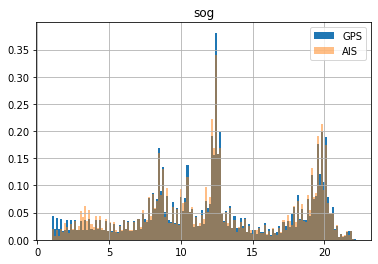

In [30]:
bins=np.linspace(df_gps['sog'].min(), df_gps['sog'].max(), 150)

fig,ax=plt.subplots()

df_gps.hist(column='sog', bins=bins, density=True, ax=ax, label='GPS');
df_ais_pos.hist(column='sog', weights=df_ais_pos['segment_time'], bins=bins, density=True, ax=ax, alpha=0.5, label='AIS')
ax.legend()


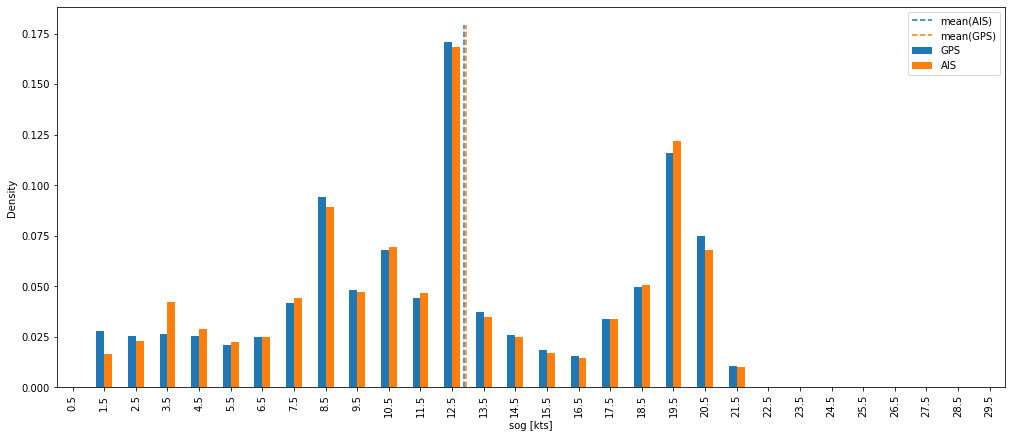

In [32]:
bins=np.arange(0,31)

index = (bins[0:-1] + bins[1:])/2
df_hist = pd.DataFrame(index=index)

df_hist['GPS'] = np.histogram(df_gps['sog'], bins=bins, density=True)[0]
df_hist['AIS'] = np.histogram(df_ais_pos['sog'], bins=bins, density=True, weights=df_ais_pos['segment_time'])[0]

fig,ax=plt.subplots()
fig.set_size_inches(17,7)
df_hist.plot.bar(ax=ax)
ax.set_xlabel('sog [kts]')
ax.set_ylabel('Density')

sog_mean_ais = np.average(df_ais_pos['sog'], weights=df_ais_pos['segment_time'])
sog_mean_gps = np.average(df_gps['sog'])

ylims = ax.get_ylim()

ax.plot([sog_mean_ais,sog_mean_ais], ylims, '--', label='mean(AIS)')
ax.plot([sog_mean_gps,sog_mean_gps], ylims, '--', label='mean(GPS)')
ax.legend();
